# Attacks using the Adversarial Robustness Toolbox (ART)

#### Attacks on a simple model using ART and Tensorflow 2.0


## Installation


In [1]:
!pip install -q tensorflow==2.0.0
!pip install adversarial-robustness-toolbox[all]

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
tf.compat.v1.disable_eager_execution()

import numpy as np
from matplotlib import pyplot as plt

import art

if tf.__version__[0] != '2':
    raise ImportError('This notebook requires TensorFlow v2.')

print("\nTensorflow Version: " + tf.__version__)
print("ART Version: " + art.__version__)
print("GPU Available: ", tf.test.is_gpu_available())

     |████████████████████████████████| 86.3 MB 39 kB/s 
     |████████████████████████████████| 50 kB 3.3 MB/s 
     |████████████████████████████████| 449 kB 24.2 MB/s 
     |████████████████████████████████| 3.8 MB 41.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-probability 0.16.0 requires gast>=0.3.2, but you have gast 0.2.2 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 5.2 MB/s 
     |████████████████████████████████| 1.1 MB 39.4 MB/s 
     |████████████████████████████████| 565 kB 67.2 MB/s 
     |████████████████████████████████| 76.8 MB 1.2 MB/s 
     |████████████████████████████████| 249 kB 59.7 MB/s 
     |████████████████████████████████| 49.1 MB 140 kB/s 
  Attempting uninstall: graphviz
    Found existing

## Training a simple model on the MNIST dataset


> If you would like to experiment with other models and datasets feel free to replace this code by whatever you need to do so. Just remember that to make the rest of the notebook work without any other major changes keep the variables train_images, train_labels, test_images, test_labels and assign them to the corresponding new data. I recommend any of the datasets offered by keras as they use the same mechanics to import them.

>Keep in mind that the MNIST dataset was used in this guide because of the little amount of time it takes to both train a good model and craft the attacks.

In [2]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images / 255.0
test_images = test_images / 255.0

num_classes = 10
num_samples = 100

test_images = test_images[0:100]
test_labels = test_labels[0:100]

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Activation(tf.nn.softmax) # We seperate the activation layer to be able to access the logits of the previous layer later
])

model.compile(optimizer='adam',
              loss= 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=10, validation_split=0.2)
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

11493376/11490434 [==============================] - 0s 0us/step


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 3s 69us/sample - loss: 0.4252 - accuracy: 0.8720 - val_loss: 0.2163 - val_accuracy: 0.9387
Epoch 2/10
48000/48000 [==============================] - 3s 66us/sample - loss: 0.1982 - accuracy: 0.9413 - val_loss: 0.1829 - val_accuracy: 0.9503
Epoch 3/10
48000/48000 [==============================] - 3s 67us/sample - loss: 0.1518 - accuracy: 0.9547 - val_loss: 0.1503 - val_accuracy: 0.9561
Epoch 4/10
48000/48000 [==============================] - 3s 68us/sample - loss: 0.1269 - accuracy: 0.9614 - val_loss: 0.1332 - val_accuracy: 0.9617
Epoch 5/10
48000/48000 [==============================] - 3s 68us/sample - loss: 0.1094 - accuracy: 0.9672 - val_loss: 0.1366 - val_accuracy: 0.9616
Epoch 6/10
48000/48000 [==============================] - 3s 67us/sample - loss: 0.0971 - accuracy: 0.9709 - val_loss: 0.1342 - val_accuracy: 0.9614
Epoch 7/10
48000/48000 [==============================] 

##Implementing Deepfool attack in ART

See the documentation here:
https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/attacks/evasion.html#deepfool

In [32]:
# Import the attack
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import DeepFool

# Create a ART Keras classifier for the TensorFlow Keras model.
logit_model = tf.keras.Model(model.input, model.layers[-2].output)
classifier = KerasClassifier(model=logit_model, clip_values=(0, 1))

### Non-targeted (error-generic) DeepFool attack
What happens if you change the epsilon value?
What happens if you change the maximum number of iterations?

DeepFool:   0%|          | 0/100 [00:00<?, ?it/s]

100/100 [==============================] - 0s 117us/sample - loss: 0.8333 - accuracy: 0.2200
Accuracy on adversarial test data: 22.00%
Average perturbation: 0.01


<Figure size 432x288 with 0 Axes>

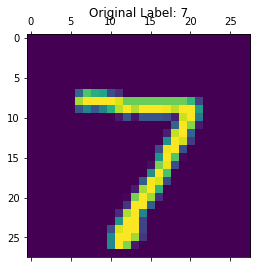

<Figure size 432x288 with 0 Axes>

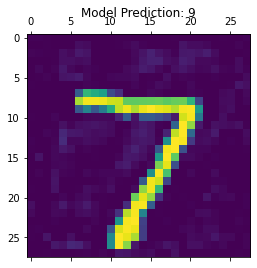

In [36]:
epsilon = 0.05
max_iter = 5

attack = DeepFool(classifier=classifier, epsilon=epsilon, max_iter=max_iter)

test_images_adv = attack.generate(test_images)

loss_test, accuracy_test = model.evaluate(test_images_adv, test_labels)
model_predictions = model.predict(test_images_adv)
perturbation = np.mean(np.abs((test_images_adv - test_images)))
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))

#Show one original example
plt.figure()
plt.matshow(test_images[0])
plt.title("Original Label: {}".format(test_labels[0]))
plt.show()

#Show the corresponding adversarial example
plt.figure()
plt.matshow(test_images_adv[0])
plt.title("Model Prediction: {}".format(np.argmax(model_predictions[0])))
plt.show()

##Implementing CW attack in ART


See the documentation here:
* https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/attacks/evasion.html#carlini-and-wagner-l-2-attack

In [67]:
# Import the attack
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import CarliniL2Method

# Create a ART Keras classifier for the TensorFlow Keras model.
logit_model = tf.keras.Model(model.input, model.layers[-2].output)
classifier = KerasClassifier(model=logit_model, clip_values=(0, 1))

### Non-targeted (error-generic) CW attack
What happens if you change the binary search step value?
What happens if you change the maximum number of iterations?
What happens if you change the confidence value?
What happens if you change the learning rate?
What happens if you change the initial const?

C&W L_2:   0%|          | 0/100 [00:00<?, ?it/s]

100/100 [==============================] - 0s 87us/sample - loss: 4.2086 - accuracy: 0.0300
Accuracy on adversarial test data: 3.00%
Average perturbation: 0.04


<Figure size 432x288 with 0 Axes>

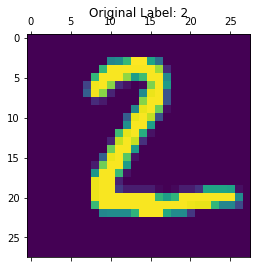

<Figure size 432x288 with 0 Axes>

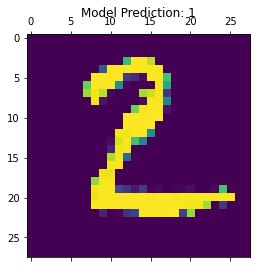

In [71]:
binary_search_steps = 1
confidence = 0.5
max_iter = 50
learning_rate = 0.01
initial_const = 1000

attack = CarliniL2Method(classifier=classifier, binary_search_steps=binary_search_steps, confidence=confidence, max_iter=max_iter, learning_rate=learning_rate, initial_const=initial_const, targeted=False)

test_images_adv = attack.generate(test_images)

loss_test, accuracy_test = model.evaluate(test_images_adv, test_labels)
model_predictions = model.predict(test_images_adv)
perturbation = np.mean(np.abs((test_images_adv - test_images)))
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))

#Show one original example
plt.figure()
plt.matshow(test_images[1])
plt.title("Original Label: {}".format(test_labels[1]))
plt.show()

#Show the corresponding adversarial example
plt.figure()
plt.matshow(test_images_adv[1])
plt.title("Model Prediction: {}".format(np.argmax(model_predictions[1])))
plt.show()

### Targeted (error-specific) CW attack
What happens if you change the binary search step value?
What happens if you change the maximum number of iterations?
What happens if you change the confidence value?
What happens if you change the learning rate?
What happens if you change the initial const?
What happens if you change the target?

C&W L_2:   0%|          | 0/100 [00:00<?, ?it/s]

100/100 [==============================] - 0s 88us/sample - loss: 6.0506 - accuracy: 0.0700
Accuracy on adversarial test data: 7.00%
Average perturbation: 0.05
100/100 [==============================] - 0s 102us/sample - loss: 0.1846 - accuracy: 1.0000
Targeted attack accuracy: 1.00


<Figure size 432x288 with 0 Axes>

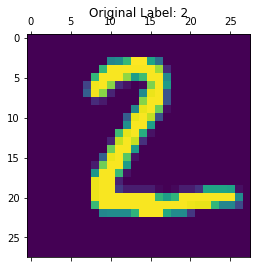

<Figure size 432x288 with 0 Axes>

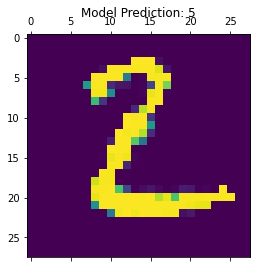

In [72]:
binary_search_steps = 1
confidence = 0.5
max_iter = 50
learning_rate = 0.01
initial_const = 1000
target_class = 5

attack = CarliniL2Method(classifier=classifier, binary_search_steps=binary_search_steps, confidence=confidence, max_iter=max_iter, learning_rate=learning_rate, initial_const=initial_const, targeted=True)

targeted_labels = target_class*np.ones(test_labels.size)
one_hot_targeted_labels = tf.keras.utils.to_categorical(targeted_labels, num_classes = num_classes)
test_images_adv = attack.generate(test_images, one_hot_targeted_labels)

loss_test, accuracy_test = model.evaluate(test_images_adv, test_labels)
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
perturbation = np.mean(np.abs((test_images_adv - test_images)))
print('Average perturbation: {:4.2f}'.format(perturbation))
targeted_attack_loss, targeted_attack_accuracy = model.evaluate(test_images_adv, targeted_labels)
print('Targeted attack accuracy: {:4.2f}'.format(targeted_attack_accuracy))

model_predictions = model.predict(test_images_adv)

#Show one original example
plt.figure()
plt.matshow(test_images[1])
plt.title("Original Label: {}".format(test_labels[1]))
plt.show()

#Show the corresponding adversarial example
plt.figure()
plt.matshow(test_images_adv[1])
plt.title("Model Prediction: {}".format(np.argmax(model_predictions[1])))
plt.show()